# From images of faces, locate facial features

## 1 EDA, simple 96x96 greyscaled images

In [3]:
# Make the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('training.csv')
print(df.columns)
print('number of features to detect : ', df.columns.shape[0] - 1)

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')
number of features to detect :  30


In [38]:
df.isna().sum()


left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

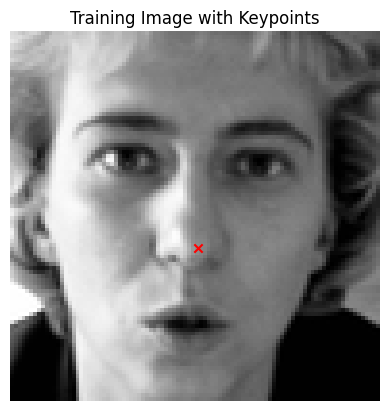

In [ ]:
idx = 1

# Example: assuming the string is in the first row
image_string = df.loc[idx, 'Image']
# Convert string to list of ints
image_array = np.fromstring(image_string, sep=' ', dtype=np.uint8)
# Reshape to original image dimensions (example: 28x28)
image_reshaped  = image_array.reshape((96, 96))
# process the keypoints
keypoints = df.drop('Image', axis=1).values[idx]

def show_results(image, keypoints):
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[0::2], keypoints[1::2], c='r', marker='x')  # every other is x, then y
    plt.title("Training Image with Keypoints")
    plt.axis('off')
    plt.show()

show_results(image_reshaped, keypoints)

## 2 Custom Dataset

In [41]:
# Some small chenking for my data
# Test if all images are the same size
for i in range(df.shape[0]):
    image_string = df.loc[i, 'Image']
    image_array = np.fromstring(image_string, sep=' ', dtype=np.uint8)
    if image_array.shape[0] != 9216:
        print('Image number ', i, ' is not the same size as the others')
        break
print('All images are the same size')

# X_train will be an array of images 
# Y_train will be be a vector with the differnet coordinate of points
import torch
X_train = df['Image'].apply(lambda x: np.fromstring(x, sep=' ', dtype=np.uint8).reshape(96, 96)).values
X_train = np.array([x for x in X_train])
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
print('x train shape', X_train.shape)

All images are the same size
x train shape torch.Size([7049, 1, 96, 96])


In [49]:
# put all of the data into the class of CustomDataset (work for small dataset)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.X_train = []

        for img_str in dataframe['Image']:
            img = np.fromstring(img_str, sep=' ', dtype=np.uint8).reshape(96, 96)
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=0)  # shape: (1, 96, 96)
            self.X_train.append(torch.tensor(img, dtype=torch.float32))

        self.X_train = torch.stack(self.X_train)  # Final shape: (N, 1, 96, 96)
        self.Y_train = torch.tensor(dataframe.drop('Image', axis=1).values, dtype=torch.float32)
        self.normalize() # Normalize the data
        
    def normalize(self):
        # Normalize the images to [0, 1]
        self.X_train = self.X_train / 255.0
        # Normalize the keypoints to [0, 1]
        self.Y_train = (self.Y_train - self.Y_train.min()) / (self.Y_train.max() - self.Y_train.min())
        return self
    
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        image = self.X_train[idx]
        label = self.Y_train[idx]
        return image, label



In [ ]:
from sklearn.model_selection import train_test_split # type: ignore
from torch.utils.data import DataLoader

df = pd.read_csv('training.csv')
df = df[['Image', 'nose_tip_x', 'nose_tip_y']] 
# Split the dataset
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Create dataset instances
train_dataset = CustomDataset(df_train)
val_dataset = CustomDataset(df_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [51]:
# Creat a CNN model for the training
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class CNN(nn.Module):
    def __init__(self, image_shape = (1,96,96), output_dim=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 24 * 24, 512)
        self.fc2 = nn.Linear(512, output_dim)  # Assuming 30 output points (x,y) pairs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


In [ ]:
# Creation of a cusotm loss function to deal with missing values
def MSE_loss_mask(pred, target, mask):
    loss = (pred - target) ** 2
    loss = loss * mask  # apply mask
    return loss.sum() / mask.sum()  # average over only valid entries

In [ ]:
# Train the CNN and see if it can detect the points
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = CNN().to(device)  # Move model to GPU if available
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
model.train() # Set the model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    i = 0
    for images, labels in train_loader:
        images = images.to(device)
        # Deal with NaNs in the labels 1-nans to 0 2-ignore loss
        labels = keypoints.to(device)
        label_mask = ~torch.isnan(labels) 
        optimizer.zero_grad()  # Zero the gradients
        #print('image shaep:', images.shape) # Should be (32, 1, 96, 96)
        outputs = model(images)  # Forward pass
        loss = MSE_loss_mask(outputs, labels, label_mask)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()
        # i += 1
        # if i % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')



# Save the model
torch.save(model.state_dict(), 'cnn_model.pth')
# Load the model
model = CNN()
model.load_state_dict(torch.load('cnn_model.pth'))
model.eval()  # Set the model to evaluation mode

# Test the model on validation set
val_loss = 0.0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        val_loss += loss.item()
        
        
print(f'Validation Loss: {val_loss/len(val_loader):.4f}')




Epoch [1/5], Step [1/177], Loss: 3251.2673
Epoch [1/5], Step [1/177], Loss: 2563.9453
Epoch [1/5], Step [1/177], Loss: 1651.1528
Epoch [1/5], Step [1/177], Loss: 673.5251
Epoch [1/5], Step [1/177], Loss: 76.6381
Epoch [1/5], Step [1/177], Loss: 659.1017
Epoch [1/5], Step [1/177], Loss: 898.4751
Epoch [1/5], Step [1/177], Loss: 504.1875
Epoch [1/5], Step [1/177], Loss: 110.6882
Epoch [1/5], Step [1/177], Loss: 64.5172
Epoch [1/5], Step [1/177], Loss: 181.7071
Epoch [1/5], Step [1/177], Loss: 317.8698
Epoch [1/5], Step [1/177], Loss: 433.7392
Epoch [1/5], Step [1/177], Loss: 445.1207
Epoch [1/5], Step [1/177], Loss: 297.2326
Epoch [1/5], Step [1/177], Loss: 161.0122
Epoch [1/5], Step [1/177], Loss: 124.9585
Epoch [1/5], Step [1/177], Loss: 49.5121
Epoch [1/5], Step [1/177], Loss: 62.8726
Epoch [1/5], Step [1/177], Loss: 144.9547
Epoch [1/5], Step [1/177], Loss: 149.5531
Epoch [1/5], Step [1/177], Loss: 216.3161
Epoch [1/5], Step [1/177], Loss: 116.2130
Epoch [1/5], Step [1/177], Loss: 67

C:\Users\Robin\AppData\Local\Temp\ipykernel_19692\460257729.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_model.pth'))


Validation Loss: 29.1143


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 0.  device
# ----------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------------------------------------------------
# 1.  Dataset (returns image, keypoints, mask) --------------------------
# ----------------------------------------------------------------------
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        imgs  = df["Image"].values
        kp    = df.drop("Image", axis=1).values.astype("float32")   # (N, 30)
        mask  = ~np.isnan(kp)
        kp[np.isnan(kp)] = 0.0
        kp = kp / 96.0             # 0‑‑1

        self.imgs  = imgs
        self.kp    = kp
        self.mask  = mask

    def __len__(self):  return len(self.imgs)

    def __getitem__(self, idx):
        img = np.fromstring(self.imgs[idx], sep=" ", dtype=np.uint8)\
                 .reshape(96,96).astype("float32") / 255.0
        img = torch.from_numpy(img).unsqueeze(0)     # (1,96,96)
        kp   = torch.from_numpy(self.kp[idx])        # (30,)
        mask = torch.from_numpy(self.mask[idx])      # (30,) bool
        return img, kp, mask

# ----------------------------------------------------------------------
# 2.  Model -------------------------------------------------------------
# ----------------------------------------------------------------------
class CNN(nn.Module):
    def __init__(self, output_dim=30):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64 * 24 * 24, 512)
        self.fc2   = nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ----------------------------------------------------------------------
# 3.  Masked loss -------------------------------------------------------
# ----------------------------------------------------------------------
def masked_mse(pred, target, mask):
    """
    Computes the masked mean squared error loss.
    Args:
        pred (torch.Tensor): The predicted keypoint values from the model.
        target (torch.Tensor): The ground truth keypoint values.
        mask (torch.Tensor): A boolean mask indicating valid keypoints (True for valid, False for missing).
    Returns:
        torch.Tensor: The scalar masked mean squared error loss.
    """
    se = (pred - target) ** 2 * mask
    denom = mask.sum(1).clamp_min(1.0)         # (B,)
    per_sample = se.sum(1) / denom             # (B,)
    return per_sample.mean()                   # scalar

# ----------------------------------------------------------------------
# 4.  Loading the Dataset ----------------------------------------------
# ----------------------------------------------------------------------
from sklearn.model_selection import train_test_split # type: ignore
from torch.utils.data import DataLoader
df = pd.read_csv('training.csv')

# Split the dataset
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
# Create dataset instances
train_dataset = CustomDataset(df_train)
val_dataset = CustomDataset(df_val)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


Device: cpu


In [ ]:

# ----------------------------------------------------------------------
# 5.  Training ---------------------------------------------------------
# ----------------------------------------------------------------------

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5

model.train()
for epoch in range(num_epochs):
    running = 0.0
    for step, (images, labels, masks) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = masked_mse(outputs, labels, masks)
        loss.backward()
        optimizer.step()

        running += loss.item()
        if (step + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}  "
                  f"Step {step+1}/{len(train_loader)}  "
                  f"Loss {loss.item():.4f}")

    print(f"Epoch {epoch+1} mean loss: {running/len(train_loader):.4f}")

# ----------------------------------------------------------------------
# 5.  Save / reload -----------------------------------------------------
# ----------------------------------------------------------------------
torch.save(model.state_dict(), "cnn_model.pth")

model = CNN().to(device)
model.load_state_dict(torch.load("cnn_model.pth"))
model.eval()

# ----------------------------------------------------------------------
# 6.  Validation --------------------------------------------------------
# ----------------------------------------------------------------------
val_loss = 0.0
with torch.no_grad():
    for images, labels, masks in val_loader:
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)
        outputs = model(images)
        val_loss += masked_mse(outputs, labels, masks).item()

print("Validation loss:", val_loss / len(val_loader))


  0%|          | 0/45 [00:00<?, ?it/s]

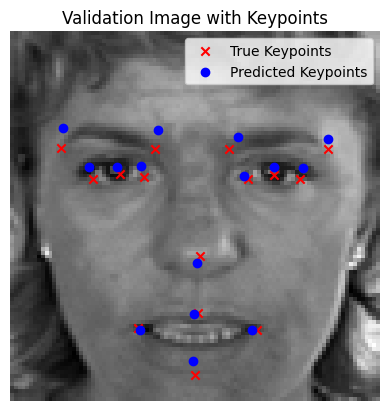

  0%|          | 0/45 [00:00<?, ?it/s]


In [2]:
# Inference part for the model
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# Load the model
model = CNN()
model.load_state_dict(torch.load('cnn_model.pth'))
model.eval()  # Set the model to evaluation mode
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
# Load the validation data
for step, (images, labels, masks) in enumerate(tqdm(val_loader)):
    images = images.to(device)
    labels = labels.to(device)
    masks  = masks.to(device)

    # Get the first image and its corresponding keypoints
    image = images[0].cpu().numpy().squeeze()  # Shape: (96, 96)
    keypoints = labels[0].cpu().numpy()  # Shape: (30,)
    keypoints = keypoints * 96.0  # Rescale to original size
    mask = masks[0].cpu().numpy()  # Shape: (30,)
    
    prediction = model(images)
    prediction = prediction[0].detach().numpy()  # Shape: (30,)
    prediction = prediction * 96.0  # Rescale to original size
    
    # show the prediction
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[0::2], keypoints[1::2], c='r', marker='x', label='True Keypoints')  # every other is x, then y
    plt.scatter(prediction[0::2], prediction[1::2], c='b', marker='o', label='Predicted Keypoints')  # every other is x, then y
    plt.title("Validation Image with Keypoints")
    plt.axis('off')
    plt.legend()
    plt.show()
    break  # Show only the first image


In [6]:
# Test the model from the webcam
import cv2
import numpy as np


# Open the webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()
# Load the model
model = CNN()
model.load_state_dict(torch.load('cnn_model.pth'))

# Use each frame from the webcam
# Resize the webcam image to 96x96 greyscale
def preprocess_image(frame):
    # Resize the frame to 96x96
    frame = cv2.resize(frame, (96, 96))
    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Normalize the image
    frame = frame.astype(np.float32) / 255.0
    # Add a batch dimension and channel dimension
    frame = np.expand_dims(frame, axis=0)  # Shape: (1, 96, 96)
    frame = np.expand_dims(frame, axis=0)  # Shape: (1, 1, 96, 96)
    return torch.tensor(frame, dtype=torch.float32)


def process_webcam_image(frame):
    width, height = frame.shape[1], frame.shape[0]
    preprocessed_frame = preprocess_image(frame)
    frame_tensor = preprocessed_frame.to(device)

    # Get prediction
    with torch.no_grad():
        prediction = model(frame_tensor)
        prediction = prediction[0].detach().cpu().numpy()
        prediction[0::2] *= width
        prediction[1::2] *= height

    # Get grayscale 96x96 image for display
    grayscale_image = preprocessed_frame[0, 0].numpy()
    return prediction, grayscale_image


while True:
    ret, frame = cap.read()
    # Crop frame to square 
    h, w = frame.shape[:2]
    min_dim = min(h, w)
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    frame = frame[start_y:start_y + min_dim, start_x:start_x + min_dim]
    
    if not ret:
        print("Error: Could not read frame.")
        break

    prediction, grayscale_image = process_webcam_image(frame)

    for i in range(0, len(prediction), 2):
        x = int(prediction[i])
        y = int(prediction[i + 1])
        cv2.circle(frame, (x, y), 3, (0, 255, 0), -1)

    # Show original frame
    cv2.imshow('Webcam Keypoints', frame)

    # Prepare and show 96x96 grayscale image
    grayscale_display = (grayscale_image * 255).astype(np.uint8)
    upscaled_grayscale = cv2.resize(grayscale_display, (256, 256), interpolation=cv2.INTER_NEAREST)
    cv2.imshow('96x96 Grayscale Input', upscaled_grayscale)

    # Exit if 'q' is pressed or any window is closed
    if (cv2.waitKey(1) & 0xFF == ord('q') or
        cv2.getWindowProperty('Webcam Keypoints', cv2.WND_PROP_VISIBLE) < 1 or
        cv2.getWindowProperty('96x96 Grayscale Input', cv2.WND_PROP_VISIBLE) < 1):
        print("Exiting...")
        break

cap.release()
cv2.destroyAllWindows()


Exiting...


# Inference Webcam issues

- need some data augmentation
- Show the image pass trought the network